# Embedding Different Variables into Different Spaces by GloVe

In this notebook we try to use Keras backend implement the optimization problem of GloVe. 
$$J = \sum_{i, j=1}^{V}f(X_{ij})((\mathbf{w}_i^k)^T\mathbf{M}^{kl}\mathbf{v_j}^l + b_i^k + a_j^l - \log X_{ij})^2$$
$$ \mathbf{W^k}, \mathbf{V^l}, \mathbf{b^k}, \mathbf{a^l} = \text{argmin}(J)$$
where $k, l \in \{DX1, DX, PR\}$

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os, sys
from importlib import reload
import scipy.sparse as sp
import time
import itertools
%matplotlib inline

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [3]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [4]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, Lambda, Multiply, Add
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K

Using TensorFlow backend.


In [5]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import Mat_reg, Parent_reg, preprocess, get_frequency, preprocess_ms
from glove import Glove, GloveMS
from setsum_layer import MaskedSum

In [6]:
from ccs_tools import dx_multi, pr_multi, dx_label, core_dtypes_pd, dx_single

## Class Developing
### Reading Data

In [7]:
cohort='ami'
tst_seed=0

In [8]:
all_df = pd.read_csv(path+'cohorts/{}/{}_pred.csv'.format(cohort, cohort), dtype=core_dtypes_pd)

In [167]:
all_df = pd.read_csv(path+'cohorts30/{}/index_comorb.csv'.format(cohort), dtype=core_dtypes_pd)

In [169]:
all_df.FEMALE.describe()

count    319244.000000
mean          0.519452
std           0.499622
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: FEMALE, dtype: float64

In [7]:
n_DX = 29
n_PR = 15
DXs = ['DX'+str(n) for n in range(2, n_DX+2)]
PRs = ['PR'+str(n) for n in range(1, n_PR+1)]

In [11]:
freq = get_frequency(all_df)

In [15]:
preprocessed = preprocess(all_df, DX_rarecutpoint=10, PR_rarecutpoint=10)

In [16]:
all_df = preprocessed['int_df']

In [17]:
tst_key = pd.read_csv(path+'cohorts/{}/tst_key{}.csv'.format(cohort, tst_seed), names = ['KEY_NRD'])
tst_df = all_df.loc[all_df.KEY_NRD.isin(tst_key.KEY_NRD)]
train_df0 = all_df.loc[~all_df.KEY_NRD.isin(tst_key.KEY_NRD)].reset_index()

In [16]:
from glove import Glove

In [17]:
embed_dim=100
count_cap=5

In [18]:
g = Glove(input_dim=len(preprocessed['code_cat']), embedding_dim=embed_dim, count_cap=count_cap)

In [19]:
g.update_cooccur(train_df0[['DX1']+DXs+PRs])

Updating co-occurrence matrix from a Dataframe with 167841 rows...
Finished. It takes 34.7 seconds to update the cooccurrences.


In [20]:
cooccur_df = g.get_cooccur_df()

In [21]:
cooccur_df.shape

(874770, 3)

In [22]:
cooccur_df.head()

,focal_index,context_index,cooccur_counts
0,1294,1131,112.0
1,1760,65,1.0
2,1082,437,12.0
3,2440,1696,3.0
4,1006,901,5172.0


### Data preparation

In [21]:
n_DX1_cat = len(preprocessed['DX1_cat'])
n_DX_cat = len(preprocessed['DX_cat'])
n_PR_cat = len(preprocessed['PR_cat'])

In [24]:
n_DX1_cat, n_DX_cat, n_PR_cat

(20, 2323, 560)

In [25]:
input_X = cooccur_df

In [26]:
input_X = input_X.assign(input_DX1_w=0).assign(input_DX_w=0).assign(input_PR_w=0).assign(input_DX1_v=0).assign(input_DX_v=0).assign(input_PR_v=0)

input_X.loc[input_X.context_index<=n_DX1_cat, 'input_DX1_w'] = input_X.loc[input_X.context_index<=n_DX1_cat, 'context_index']

input_X.loc[(n_DX1_cat<input_X.context_index) & (input_X.context_index<=n_DX1_cat+n_DX_cat), 
            'input_DX_w'] = input_X.loc[(n_DX1_cat<input_X.context_index) & (input_X.context_index<=n_DX1_cat+n_DX_cat), 
                                        'context_index'] - n_DX1_cat

input_X.loc[input_X.context_index>n_DX1_cat+n_DX_cat, 
            'input_PR_w'] = input_X.loc[input_X.context_index>n_DX1_cat+n_DX_cat, 'context_index'] - n_DX1_cat - n_DX_cat

input_X.loc[input_X.focal_index<=n_DX1_cat, 'input_DX1_v'] = input_X.loc[input_X.focal_index<=n_DX1_cat, 'focal_index']

input_X.loc[(n_DX1_cat<input_X.focal_index) & (input_X.focal_index<=n_DX1_cat+n_DX_cat), 
            'input_DX_v'] = input_X.loc[(n_DX1_cat<input_X.focal_index) & (input_X.focal_index<=n_DX1_cat+n_DX_cat), 
                                        'focal_index'] - n_DX1_cat

input_X.loc[input_X.focal_index>n_DX1_cat+n_DX_cat, 
            'input_PR_v'] = input_X.loc[input_X.focal_index>n_DX1_cat+n_DX_cat, 'focal_index'] - n_DX1_cat - n_DX_cat

In [27]:
input_X.head(20)

,focal_index,context_index,cooccur_counts,input_DX1_w,input_DX_w,input_PR_w,input_DX1_v,input_DX_v,input_PR_v
0,1294,1131,112.0,0,1111,0,0,1274,0
1,1760,65,1.0,0,45,0,0,1740,0
2,1082,437,12.0,0,417,0,0,1062,0
3,2440,1696,3.0,0,1676,0,0,0,97
4,1006,901,5172.0,0,881,0,0,986,0
5,1891,877,4.0,0,857,0,0,1871,0
6,2159,1600,1.0,0,1580,0,0,2139,0
7,2826,1235,1.0,0,1215,0,0,0,483
8,1294,710,2.0,0,690,0,0,1274,0
9,1757,876,11.0,0,856,0,0,1737,0


In [37]:
DX1_w_trn = input_X['input_DX1_w'].values
DX1_v_trn = input_X['input_DX1_v'].values
DX_w_trn = input_X['input_DX_w'].values
DX_v_trn = input_X['input_DX_v'].values
PR_w_trn = input_X['input_PR_w'].values
PR_v_trn = input_X['input_PR_v'].values

In [39]:
y = np.log(input_X.cooccur_counts.values)

In [40]:
def weighting_factor(count, count_cap=5, scaling_factor=0.75):
    if count>=count_cap:
        return 1.
    else:
        return np.power(count/count_cap, scaling_factor)

In [41]:
weights = input_X.cooccur_counts.apply(weighting_factor).values

### Model building.

In [42]:
DX1_embed_dim = 10
DX_embed_dim = 100
PR_embed_dim = 50

In [43]:
input_DX1_w = Input(shape=(1,), name='input_focal_DX1')
input_DX_w = Input(shape=(1,), name='input_focal_DX')
input_PR_w = Input(shape=(1,), name='input_focal_PR')
input_DX1_v = Input(shape=(1,), name='input_context_DX1')
input_DX_v = Input(shape=(1,), name='input_context_DX')
input_PR_v = Input(shape=(1,), name='input_context_PR')

DX1_embed_layer = Embedding(input_dim=n_DX1_cat+1, output_dim=DX1_embed_dim, name='DX1_embed', mask_zero=True)
DX_embed_layer = Embedding(input_dim=n_DX_cat+1, output_dim=DX_embed_dim, name='DX_embed', mask_zero=True)
PR_embed_layer = Embedding(input_dim=n_PR_cat+1, output_dim=PR_embed_dim, name='PR_embed', mask_zero=True)

DX1_bias_layer = Embedding(input_dim=n_DX1_cat+1, output_dim=1, name='DX1_bias', mask_zero=True)
DX_bias_layer = Embedding(input_dim=n_DX_cat+1, output_dim=1, name='DX_bias', mask_zero=True)
PR_bias_layer = Embedding(input_dim=n_PR_cat+1, output_dim=1, name='PR_bias', mask_zero=True)

embed_DX1_w = DX1_embed_layer(input_DX1_w)
embed_DX1_v = DX1_embed_layer(input_DX1_v)
embed_DX_w = DX_embed_layer(input_DX_w)
embed_DX_v = DX_embed_layer(input_DX_v)
embed_PR_w = PR_embed_layer(input_PR_w)
embed_PR_v = PR_embed_layer(input_PR_v)

bias_DX1_w = DX1_bias_layer(input_DX1_w)
bias_DX1_v = DX1_bias_layer(input_DX1_v)
bias_DX_w = DX_bias_layer(input_DX_w)
bias_DX_v = DX_bias_layer(input_DX_v)
bias_PR_w = PR_bias_layer(input_PR_w)
bias_PR_v = PR_bias_layer(input_PR_v)

bias_DX1_w = Masking()(bias_DX1_w)
bias_DX1_v = Masking()(bias_DX1_v)
bias_DX_w = Masking()(bias_DX_w)
bias_DX_v = Masking()(bias_DX_v)
bias_PR_w = Masking()(bias_PR_w)
bias_PR_v = Masking()(bias_PR_v)

inner_DX1_DX = InnerProduct(matrix_shape=(DX1_embed_dim, DX_embed_dim), name='DX1dotDX')([embed_DX1_w, embed_DX_v])
inner_DX1_PR = InnerProduct(matrix_shape=(DX1_embed_dim, PR_embed_dim), name='DX1dotPR')([embed_DX1_w, embed_PR_v])
inner_DX_DX = InnerProduct(matrix_shape=(DX_embed_dim, DX_embed_dim), 
                           kernel_initializer=Constant(np.eye(DX_embed_dim)), name='DXdotDX')([embed_DX_w, embed_DX_v])
inner_PR_PR = InnerProduct(matrix_shape=(PR_embed_dim, PR_embed_dim), 
                           kernel_initializer=Constant(np.eye(PR_embed_dim)), name='PRdotPR')([embed_PR_w, embed_PR_v])
inner_DX_PR = InnerProduct(matrix_shape=(DX_embed_dim, PR_embed_dim), name='DXdotPR')([embed_DX_w, embed_PR_v])

bias_concat = Concatenate(axis=-1)([bias_DX1_w, bias_DX1_v, bias_DX_w, bias_DX_v, bias_PR_w, bias_PR_v])
bias_sum = Lambda(lambda x:K.sum(x, axis=-1, keepdims=False))(bias_concat)
inner_bias_sum = Add()([inner_DX1_DX, inner_DX1_PR, inner_DX_DX, inner_DX_PR, inner_PR_PR, bias_sum])

model = Model(inputs=[input_DX1_w, input_DX_w, input_PR_w, input_DX1_v, input_DX_v, input_PR_v], outputs=inner_bias_sum)

NameError: name 'Masking' is not defined

In [144]:
for l in model.layers:
    if (l.name=='DXdotDX') or (l.name=='PRdotPR'):
        l.trainable = False

In [145]:
model.compile(loss='mse', optimizer='adam')

In [146]:
earlystop_patience = 20
reducelr_patience = 10
batch_size = 128
epochs = 30

In [147]:
checkpoint = ModelCheckpoint(filepath=model_path+'glove_multi_temp.h5', monitor='loss', save_best_only=True, 
                             save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=reducelr_patience, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='loss', patience=earlystop_patience)

In [148]:
hist = model.fit([DX1_w_trn, DX_w_trn, PR_w_trn, DX1_v_trn, DX_v_trn, PR_v_trn], y, batch_size=batch_size, epochs=epochs,
                         sample_weight=weights, callbacks=[checkpoint, reduce_lr, earlystop], verbose=1)

Epoch 1/30
874770/874770 [==============================] - 76s 87us/step - loss: 0.5092
Epoch 2/30
874770/874770 [==============================] - 75s 86us/step - loss: 0.1507
Epoch 3/30
874770/874770 [==============================] - 75s 86us/step - loss: 0.1222
Epoch 4/30
874770/874770 [==============================] - 75s 86us/step - loss: 0.1088
Epoch 5/30
762368/874770 [=========================>....] - ETA: 9s - loss: 0.1001

KeyboardInterrupt: 

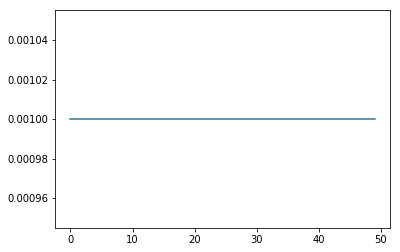

In [137]:
plt.plot(hist.history['lr'])

In [30]:
from keras.engine.topology import InputSpec, Layer

In [31]:
class InnerProduct(Layer):
    """The layer to perform a inner-product of two vectors through a matrix.   

    # Arguments
        matrix_shape: (dim1, dim2), shape of the matrix between the two vectors. 
        kernel_initializer: Initializer for the `kernel` weights matrix
    # Input shape
        [(batch, dim1), (batch, dim2)]
    # Output shape
        (batch, 1). This Dense layer works on the feature axis, and output units dimension.  
    """
    def __init__(self, matrix_shape=None,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(InnerProduct, self).__init__(**kwargs)
        self.matrix_shape = matrix_shape
        self.kernel_initializer = kernel_initializer
        self.supports_masking = True

    def build(self, input_shape):
        input_shape1, input_shape2 = input_shape
        if self.matrix_shape is None:
            self.matrix_shape = (input_shape1[-1], input_shape2[-1])
        elif not self.matrix_shape == (input_shape1[-1], input_shape2[-1]):
            raise ValueError('Initializer shape conflicts with inpute shape!')

        self.kernel = self.add_weight(shape=self.matrix_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel')
        self.built = True

    def call(self, inputs, mask=None):
        if not mask is None:
            mask1, mask2 = mask
        input1, input2 = inputs
        output = K.dot(input1, self.kernel)*input2
        output = K.sum(output, axis=-1)
        #mask1 = K.expand_dims(mask1)
        #mask2 = K.expand_dims(mask2)
        #print(output.shape, mask1.shape, mask2.shape)
        output = output*K.cast(mask1, 'float32')*K.cast(mask2, 'float32')
        return output

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        input_shape1, input_shape2 = input_shape
        assert input_shape1[0] == input_shape2[0]
        return (input_shape1[0], 1)
    
    def compute_mask(self, inputs, input_mask=None):
        return None

    def get_config(self):
        config = {
            'matrix_shape': self.matrix_shape,
            'kernel_initializer': initializers.serialize(self.kernel_initializer)
        }
        base_config = super(Dense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [78]:
class Masking(Layer):
    """The layer to multipy the input with its mask.   

    # Arguments
        matrix_shape: (dim1, dim2), shape of the matrix between the two vectors. 
        kernel_initializer: Initializer for the `kernel` weights matrix
    # Input shape
        [(batch, dim1), (batch, dim2)]
    # Output shape
        (batch, 1). This Dense layer works on the feature axis, and output units dimension.  
    """
    def __init__(self, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(Masking, self).__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        self.built = True

    def call(self, inputs, mask=None):
        if mask is None:
            return inputs
        if K.ndim(mask)<K.ndim(inputs):
            mask_expand = K.expand_dims(mask)
        else:
            mask_expand = mask
        if not inputs.shape[1:]==mask_expand.shape[1:]:
            raise ValueError("The shapes of inputs and mask don't match!")
        output = inputs*K.cast(mask_expand, 'float32')
        return output

    def compute_output_shape(self, input_shape):
        return input_shape
    
    def compute_mask(self, inputs, input_mask=None):
        return None

### Parent regularization

In [28]:
import utils
reload(utils)
from utils import preprocess_ms

In [25]:
all_df = pd.read_csv(path+'cohorts/{}/{}_pred.csv'.format(cohort, cohort), dtype=core_dtypes_pd)

In [26]:
freq = get_frequency(all_df)

In [34]:
DX_rarecutpoint = 10
PR_rarecutpoint = 10

In [15]:
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

In [35]:
DX1_cat = sorted(freq['DX1'].index)
DX_cat = sorted(freq['DX'].loc[(freq['DX']>DX_rarecutpoint) & (~freq['DX'].index.isin(unclassified)) & 
                                   (~freq['DX'].index.isin(['invl', 'incn']))].index)
PR_cat = sorted(freq['PR'].loc[(freq['PR']>PR_rarecutpoint) & (~freq['PR'].index.isin(['invl', 'incn']))].index)

In [17]:
preprocessed_ms = preprocess_ms(all_df.iloc[:10], DX1_cat=DX1_cat, DX_cat=DX_cat, PR_cat=PR_cat)

In [37]:
preprocessed_ms['int_df'][['DX1']+DXs+PRs]

,DX1,DX2,DX3,DX4,DX5,DX6,DX7,DX8,DX9,DX10,...,PR6,PR7,PR8,PR9,PR10,PR11,PR12,PR13,PR14,PR15
0,2,1374,1421,810,309,297,760,212,801,0,...,15,0,0,0,0,0,0,0,0,0
1,16,881,1371,756,888,282,801,1378,2195,802,...,0,0,0,0,0,0,0,0,0,0
2,16,2312,325,494,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16,494,801,749,0,0,0,0,0,0,...,25,102,0,0,0,0,0,0,0,0
4,6,1062,2195,1274,308,104,1150,318,1111,129,...,378,59,366,58,307,176,102,269,289,0
5,4,801,810,282,0,0,0,0,0,0,...,102,0,0,0,0,0,0,0,0,0
6,16,0,2274,447,414,540,217,2275,2271,1216,...,102,0,0,0,0,0,0,0,0,0
7,16,114,144,1148,1173,814,494,318,881,884,...,0,0,0,0,0,0,0,0,0,0
8,16,282,2234,2129,801,2046,1111,2195,866,529,...,88,166,0,0,0,0,0,0,0,0
9,16,801,212,362,375,2233,297,279,749,1216,...,0,0,0,0,0,0,0,0,0,0


In [18]:
dx1_ccs_dict = preprocessed_ms['dx1_ccs_dict']
dx_ccs_dict = preprocessed_ms['dx_ccs_dict']
pr_ccs_dict = preprocessed_ms['pr_ccs_dict']

In [19]:
dx1_parent_pairs = preprocessed_ms['dx1_parent_pairs']
dx_parent_pairs = preprocessed_ms['dx_parent_pairs']
pr_parent_pairs = preprocessed_ms['pr_parent_pairs']

## Class Testing

In [21]:
import glove
reload(glove)

<module 'glove' from '/home/wsliu/Codes/DLproj/NRD/glove.py'>

In [9]:
from glove import GloveMS

In [17]:
glovems = GloveMS(n_DX1_cat=n_DX1_cat, n_DX_cat=n_DX_cat, n_PR_cat=n_PR_cat, DX1_dim=100, DX_dim=200, PR_dim=100, count_cap = 5, 
                 scaling_factor=0.75)

In [23]:
glovems.update_cooccur(train_df0[['DX1']+DXs+PRs])

Updating co-occurrence matrix from a Dataframe with 167841 rows...
Finished. It takes 29.9 seconds to update the cooccurrences.


In [24]:
cooccur_df = glovems.get_cooccur_df()

In [82]:
glovems = GloveMS(n_DX1_cat=n_DX1_cat, n_DX_cat=n_DX_cat, n_PR_cat=n_PR_cat, n_dx1_ccs=len(dx1_ccs_dict), 
                  n_dx_ccs=len(dx_ccs_dict), n_pr_ccs=len(pr_ccs_dict), DX1_dim=10, DX_dim=100, PR_dim=50, count_cap = 5, 
                 scaling_factor=0.75)

In [83]:
glovems.train_glove(cooccur_df=cooccur_df, cache_path=model_path, dx1_parent_pairs=dx1_parent_pairs, 
                    dx_parent_pairs=dx_parent_pairs, pr_parent_pairs=pr_parent_pairs, lamb=1., metric='l2', verbose=1)

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Epoch 1/50
858534/858534 [==============================] - 14s 16us/step - loss: 0.8613
Epoch 2/50
858534/858534 [==============================] - 14s 16us/step - loss: 0.2430
Epoch 3/50
858534/858534 [==============================] - 13s 15us/step - loss: 0.1950
Epoch 4/50
858534/858534 [==============================] - 13s 15us/step - loss: 0.1757
Epoch 5/50
858534/858534 [==============================] - 13s 15us/step - loss: 0.1651
Epoch 6/50
858534/858534 [==============================] - 13s 15us/step - loss: 0.1592
Epoch 7/50
858534/858534 [==============================] - 13s 16us/step - loss: 0.1554
Epoch 8/50
858534/858534 [==============================] - 13s 15us/step - loss: 0.1527
Epoch 9/50
858534/858534 [==============================] - 13s 15us/step - loss: 0.1508
Epoch 10/50
858534/858534 [==============================] - 13s 15us/step - loss: 0.1493
Epoch 11/50
858534/858534 [========

In [84]:
embeds = glovems.get_embed_mat()

In [49]:
embeds.keys()

dict_keys(['DX_embed', 'DX1_embed', 'DX1_bias', 'PR_bias', 'DX_bias', 'PR_embed'])

In [42]:
matrices = glovems.get_matrices()

In [44]:
matrices['DXdotPR'].shape

(100, 50)

### Co-Occurences from Whole Database

In [15]:
from ccs_tools import core_cols, core_dtypes_pd, na_values, dx_multi
from utils import get_frequency, preprocess

In [16]:
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

### Elder patients

In [30]:
DX1_freq = pd.read_csv(path+'elder/DX1_freq.csv', dtype={'DX1':str, 'frequency':int})
DX_freq = pd.read_csv(path+'elder/DX_freq.csv', dtype={'DX':str, 'frequency':int})
PR_freq = pd.read_csv(path+'elder/PR_freq.csv', dtype={'PR':str, 'frequency':int})

All patients:

In [8]:
DX1_freq = pd.read_csv(path+'all/DX1_freq.csv', dtype={'DX1':str, 'frequency':int})
DX_freq = pd.read_csv(path+'all/DX_freq.csv', dtype={'DX':str, 'frequency':int})
PR_freq = pd.read_csv(path+'all/PR_freq.csv', dtype={'PR':str, 'frequency':int})

In [9]:
DX1_freq = DX1_freq.loc[DX1_freq.frequency>0]
DX_freq = DX_freq.loc[DX_freq.frequency>0]
PR_freq = PR_freq.loc[PR_freq.frequency>0]

In [12]:
sum(DX1_freq.DX1.isin(unclassified))/len(DX1_freq)

0.010854243022272343

In [13]:
sum(DX_freq.DX.isin(unclassified))/len(DX_freq)

0.027847340478813983

In [12]:
sum(DX1_freq.frequency< 10)/len(DX1_freq), sum(DX_freq.frequency< 10)/len(DX_freq), sum(PR_freq.frequency< 10)/len(PR_freq)

(0.41598533972371016, 0.26755484323349693, 0.2205188679245283)

In [10]:
DX1_rarecutpoint = 10
DX_rarecutpoint = 10
PR_rarecutpoint = 10

In [17]:
DX1_cat = sorted(DX1_freq.loc[(DX1_freq.frequency>DX1_rarecutpoint) & (~DX1_freq.DX1.isin(unclassified))].DX1)
DX_cat = sorted(DX_freq.loc[(DX_freq.frequency>DX_rarecutpoint) & (~DX_freq.DX.isin(unclassified))].DX)
PR_cat = sorted(PR_freq.loc[(PR_freq.frequency>PR_rarecutpoint)].PR)

In [18]:
n_DX1_cat = len(DX1_cat)
n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)

In [13]:
len(DX1_cat), len(DX_cat), len(PR_cat)

(6572, 9625, 3183)

In [19]:
len(DX1_cat), len(DX_cat), len(PR_cat)

(6572, 9625, 3183)

In [35]:
g = Glove(input_dim=len(DX1_cat)+len(DX_cat)+len(PR_cat)+1, embedding_dim=100, count_cap=10)

In [36]:
dxpr_df = pd.read_csv(path+'raw/2014/NRD_2014_Core.CSV', sep=',', 
                           header = None, 
                           names=core_cols, 
                           dtype=core_dtypes_pd, 
                           na_values=na_values, 
                           chunksize=500000)

In [37]:
chunk_id = 0
start = time.time()
for df in dxpr_df:
    elder = df.loc[df.AGE>=65]
    preprocessed = preprocess(elder, DX1_cat=DX1_cat, DX_cat=DX_cat, PR_cat=PR_cat)
    int_df = preprocessed['int_df']
    g.update_cooccur(int_df[['DX1']+DXs+PRs])
    print('Chunk {} finished. It takes {:.1f} seconds.'.format(chunk_id, time.time()-start))
    chunk_id += 1
    start = time.time()

Updating co-occurrence matrix from a Dataframe with 188149 rows...
Finished. It takes 40.4 seconds to update the cooccurrences.
Chunk 0 finished. It takes 56.6 seconds.
Updating co-occurrence matrix from a Dataframe with 190622 rows...
Finished. It takes 39.9 seconds to update the cooccurrences.
Chunk 1 finished. It takes 56.1 seconds.
Updating co-occurrence matrix from a Dataframe with 208351 rows...
Finished. It takes 43.6 seconds to update the cooccurrences.
Chunk 2 finished. It takes 60.3 seconds.
Updating co-occurrence matrix from a Dataframe with 190596 rows...
Finished. It takes 41.2 seconds to update the cooccurrences.
Chunk 3 finished. It takes 57.5 seconds.
Updating co-occurrence matrix from a Dataframe with 188516 rows...
Finished. It takes 39.3 seconds to update the cooccurrences.
Chunk 4 finished. It takes 55.6 seconds.
Updating co-occurrence matrix from a Dataframe with 195656 rows...
Finished. It takes 40.6 seconds to update the cooccurrences.
Chunk 5 finished. It takes 

In [38]:
cooccur_all = g.get_cooccur_df()

In [39]:
cooccur_all.shape

(10231119, 3)

In [19]:
cooccur_all.shape

(9913850, 3)

In [40]:
cooccur_all.to_csv(path+'elder/cooccur_df.csv', index=False)

In [18]:
cooccur_all = pd.read_csv(path+'multi_space_glove/cooccur_df_all.csv')

In [19]:
preprocessed_ms = preprocess_ms(all_df.iloc[:10], DX1_cat=DX1_cat, DX_cat=DX_cat, PR_cat=PR_cat)

In [20]:
dx1_parent_pairs = preprocessed_ms['dx1_parent_pairs']
dx_parent_pairs = preprocessed_ms['dx_parent_pairs']
pr_parent_pairs = preprocessed_ms['pr_parent_pairs']

In [96]:
glovems = GloveMS(n_DX1_cat=len(DX1_cat), n_DX_cat=len(DX_cat), n_PR_cat=len(PR_cat), DX1_dim=50, DX_dim=200, PR_dim=100, 
                  n_dx1_ccs=len(preprocessed_ms['dx1_ccs_dict']), n_dx_ccs=len(preprocessed_ms['dx_ccs_dict']), 
                  n_pr_ccs=len(preprocessed_ms['pr_ccs_dict']), count_cap = 20, scaling_factor=0.75)

In [97]:
glovems.train_glove(cooccur_df=cooccur_all, cache_path=model_path, epochs=20, verbose=1, dx1_parent_pairs=dx1_parent_pairs, 
                   dx_parent_pairs=dx_parent_pairs, pr_parent_pairs=pr_parent_pairs, lamb=0., metric='l2', batch_size=1024*8)

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Epoch 1/20
17141156/17141156 [==============================] - 44s 3us/step - loss: 0.6539
Epoch 2/20
17141156/17141156 [==============================] - 43s 2us/step - loss: 0.1854
Epoch 3/20
17141156/17141156 [==============================] - 43s 2us/step - loss: 0.1279
Epoch 4/20
17141156/17141156 [==============================] - 43s 2us/step - loss: 0.1020
Epoch 5/20
17141156/17141156 [==============================] - 43s 2us/step - loss: 0.0889
Epoch 6/20
17141156/17141156 [==============================] - 43s 2us/step - loss: 0.0815
Epoch 7/20
17141156/17141156 [==============================] - 43s 2us/step - loss: 0.0767
Epoch 8/20
17141156/17141156 [==============================] - 43s 2us/step - loss: 0.0734
Epoch 9/20
17141156/17141156 [==============================] - 43s 2us/step - loss: 0.0710
Epoch 10/20
17141156/17141156 [==============================] - 43s 2us/step - loss: 0.0692
Epoch

In [21]:
glovems = GloveMS(n_DX1_cat=n_DX1_cat, n_DX_cat=n_DX_cat, n_PR_cat=n_PR_cat, DX1_dim=200, DX_dim=200, PR_dim=100, count_cap = 5, 
                 scaling_factor=0.75)

In [22]:
glovems.train_glove(cooccur_df=cooccur_all, cache_path=model_path, epochs=100, verbose=1, batch_size=1024*8, reducelr_patience=3)

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Epoch 1/100
17141156/17141156 [==============================] - 75s 4us/step - loss: 0.8094
Epoch 2/100
17141156/17141156 [==============================] - 54s 3us/step - loss: 0.2738
Epoch 3/100
17141156/17141156 [==============================] - 53s 3us/step - loss: 0.2034
Epoch 4/100
17141156/17141156 [==============================] - 54s 3us/step - loss: 0.1724
Epoch 5/100
17141156/17141156 [==============================] - 53s 3us/step - loss: 0.1559
Epoch 6/100
17141156/17141156 [==============================] - 54s 3us/step - loss: 0.1456
Epoch 7/100
17141156/17141156 [==============================] - 54s 3us/step - loss: 0.1385
Epoch 8/100
17141156/17141156 [==============================] - 54s 3us/step - loss: 0.1334
Epoch 9/100
17141156/17141156 [==============================] - 53s 3us/step - loss: 0.1296
Epoch 10/100
17141156/17141156 [==============================] - 54s 3us/step - loss: 0.

In [23]:
embeds = glovems.get_embed_mat()

## Embedding Visualization

In [5]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [6]:
from collections import defaultdict

In [7]:
embeds = np.load(path+'multi_space_glove/embed_mats/10/embed_mats_200_200_50_cosine0.0_20.npz')

In [21]:
DX_embed_mat = embeds['DX_embed'][1:(n_DX_cat+1), :]
#DX_bias_mat = embeds['DX_bias'][1:(n_DX_cat+1), :]

In [56]:
DX1_embed_mat = embeds['DX1_embed'][1:(n_DX1_cat+1), :]
#DX1_bias_mat = embeds['DX1_bias'][1:(n_DX1_cat+1), :]

In [53]:
np.save(path+'embed_mat/DX_embed_all10_200_200_100_5.npy', DX_embed_mat)

In [27]:
np.save(path+'embed_mat/DX1_embed_all_200_200_100_5.npy', DX1_embed_mat)

In [15]:
DX_embed_mat = np.load(path+'embed_mat/DX_embed_all10_200_200_100_5.npy')

In [29]:
DX1_embed_mat.shape

(9766, 200)

In [30]:
DX_freq = pd.read_csv(path+'all/DX_freq.csv')
DX1_freq = pd.read_csv(path+'all/DX1_freq.csv')
PR_freq = pd.read_csv(path+'all/PR_freq.csv')

In [22]:
DX_freq = DX_freq.loc[DX_freq.DX.isin(DX_cat)]

In [57]:
DX1_freq = DX1_freq.loc[DX1_freq.DX1.isin(DX1_cat)]

In [32]:
DX1_freq.shape

(9766, 2)

DX bias vs. marginal frequency:

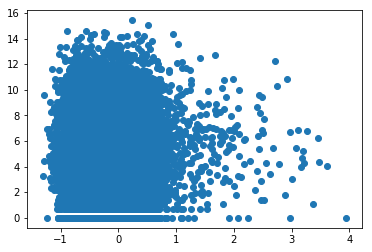

In [36]:
plt.scatter(DX_bias_mat[:, 0], np.log(DX_freq.frequency.values))

### DX visualization

In [23]:
DX_embed_mat_all = DX_embed_mat.copy()

In [24]:
freq_cutpoint=10

In [25]:
DX_cat_clean = sorted(DX_freq.loc[DX_freq.frequency>freq_cutpoint, 'DX'].values)

In [26]:
DX_embed_mat = DX_embed_mat_all[(DX_freq.frequency>freq_cutpoint).values, :]

In [27]:
len(DX_cat_clean), DX_embed_mat.shape

(9625, (9625, 200))

In [28]:
tsne = TSNE(n_components=2, init='random', random_state=0)

In [301]:
np.linalg.norm(DX_embed_mat, axis=1)[:30]

array([0.32394037, 0.28432164, 0.65459794, 0.30312923, 0.31034273,
       1.2827235 , 0.9313962 , 0.33590892, 0.2954793 , 0.3230257 ,
       0.4581076 , 0.39290088, 0.6889468 , 0.7457291 , 1.128876  ,
       0.6222342 , 0.45680752, 0.32847703, 0.56765735, 0.7072011 ,
       0.8553851 , 0.4627136 , 0.4072627 , 0.3106956 , 0.28324115,
       0.3085212 , 0.31954533, 0.737199  , 1.4146332 , 0.3185637 ],
      dtype=float32)

In [29]:
start = time.time()
DX_tsne = tsne.fit_transform(DX_embed_mat)
print('Time used: {} sec'.format(time.time()-start))

Time used: 102.34058213233948 sec


In [30]:
plot_df = pd.DataFrame(dict(x=DX_tsne[:, 0], y=DX_tsne[:, 1]), index=DX_cat_clean)

CCS category labels:

In [31]:
DX_freq = DX_freq.set_index(DX_freq.DX)

In [52]:
plot_df = plot_df.assign(ccs_lvl1=[dx_multi.loc[dx, 'CCS_LVL1']+' '+dx_multi.loc[dx, 'CCS_LVL1_LABEL'] for dx in plot_df.index])
plot_df = plot_df.assign(ccs_lvl2=[dx_multi.loc[dx, 'CCS_LVL2']+' '+dx_multi.loc[dx, 'CCS_LVL2_LABEL'] for dx in plot_df.index])
plot_df = plot_df.assign(ccs_lvl3=[dx_multi.loc[dx, 'CCS_LVL3']+' '+dx_multi.loc[dx, 'CCS_LVL3_LABEL'] for dx in plot_df.index])
plot_df = plot_df.assign(freq=DX_freq.loc[plot_df.index, 'frequency'])
plot_df = plot_df.assign(dot_size=plot_df.freq.apply(lambda x:np.log(x+1)**2.3/10))

In [53]:
colors = ['C{}'.format(j) for j in range(10)]

In [54]:
#groups = plot_df.groupby('freq_label')
groups = plot_df.groupby('ccs_lvl1')
gkey = groups.size().sort_values(ascending=False).index

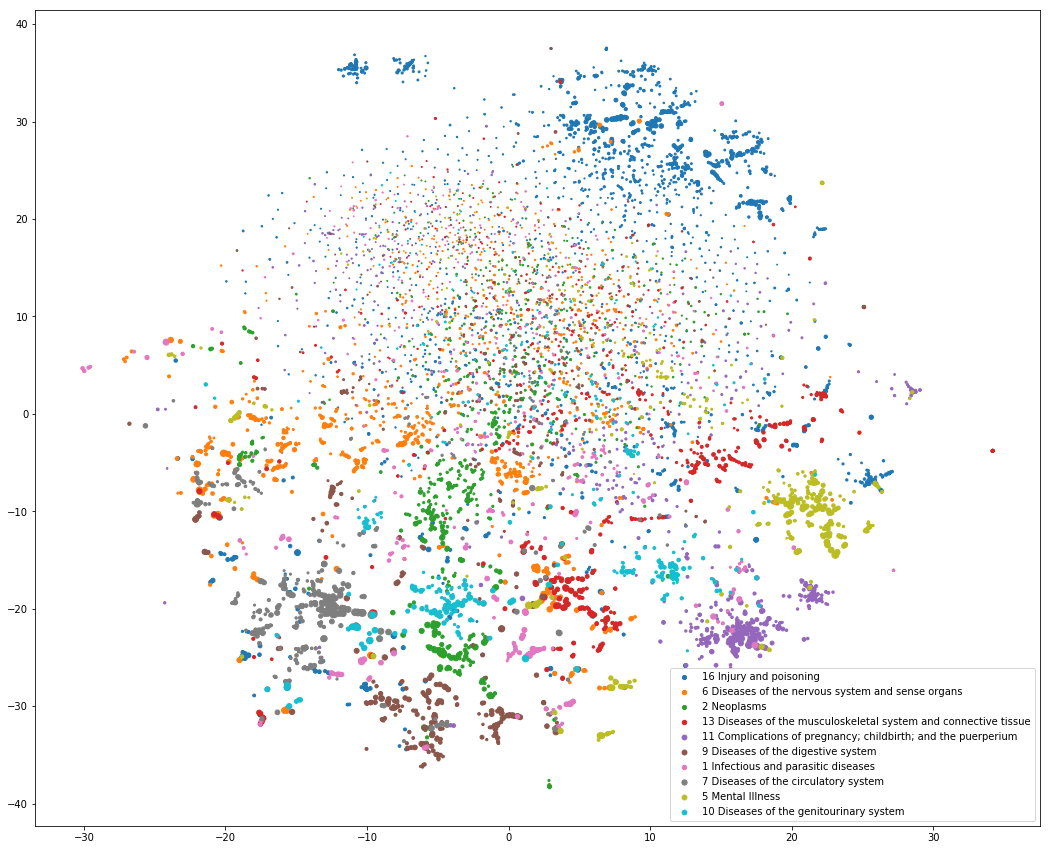

In [55]:
fig, ax = plt.subplots(figsize=(18, 15))
for ccs_lvl1, color in zip(gkey[:10], itertools.cycle(colors)):
    group = groups.get_group(ccs_lvl1)
    ax.scatter(group.x, group.y, marker='o', s=group.dot_size.values, label=ccs_lvl1, c=color)
    #plt.annotate(name, xy=(group.x.values, group.y.values), xytext=(group.x.values, group.y.values))
ax.legend()
plt.savefig('plots/DX_embed_all10_200_200_50_20.png', dpi=300, bbox_inches='tight')

In [55]:
plot_df.ccs_lvl1.value_counts()

16 Injury and poisoning                                                                 1972
6 Diseases of the nervous system and sense organs                                       1060
2 Neoplasms                                                                              846
13 Diseases of the musculoskeletal system and connective tissue                          687
11 Complications of pregnancy; childbirth; and the puerperium                            680
9 Diseases of the digestive system                                                       544
1 Infectious and parasitic diseases                                                      497
7 Diseases of the circulatory system                                                     488
5 Mental Illness                                                                         483
10 Diseases of the genitourinary system                                                  444
14 Congenital anomalies                                               

In [136]:
plot_df = plot_df.assign(label='other')
plot_df.loc[plot_df.ccs_lvl1=='16 Injury and poisoning', 'label'] = '16 Injury and poisoning'
plot_df.loc[plot_df.ccs_lvl1=='11 Complications of pregnancy; childbirth; and the puerperium', 'label'] = '11 Complications of pregnancy; childbirth; and the puerperium'

In [48]:
plot_df = plot_df.assign(label='other')
plot_df.loc[plot_df.ccs_lvl1=='7 Diseases of the circulatory system', 'label'] = '7 Diseases of the circulatory system'
plot_df.loc[plot_df.ccs_lvl1=='8 Diseases of the respiratory system', 'label'] = '8 Diseases of the respiratory system'

In [49]:
#groups = plot_df.groupby('freq_label')
groups = plot_df.groupby('label')
gkey = groups.size().sort_values(ascending=False).index

In [50]:
colors = ['0.7']+ ['C{}'.format(j) for j in range(2)]

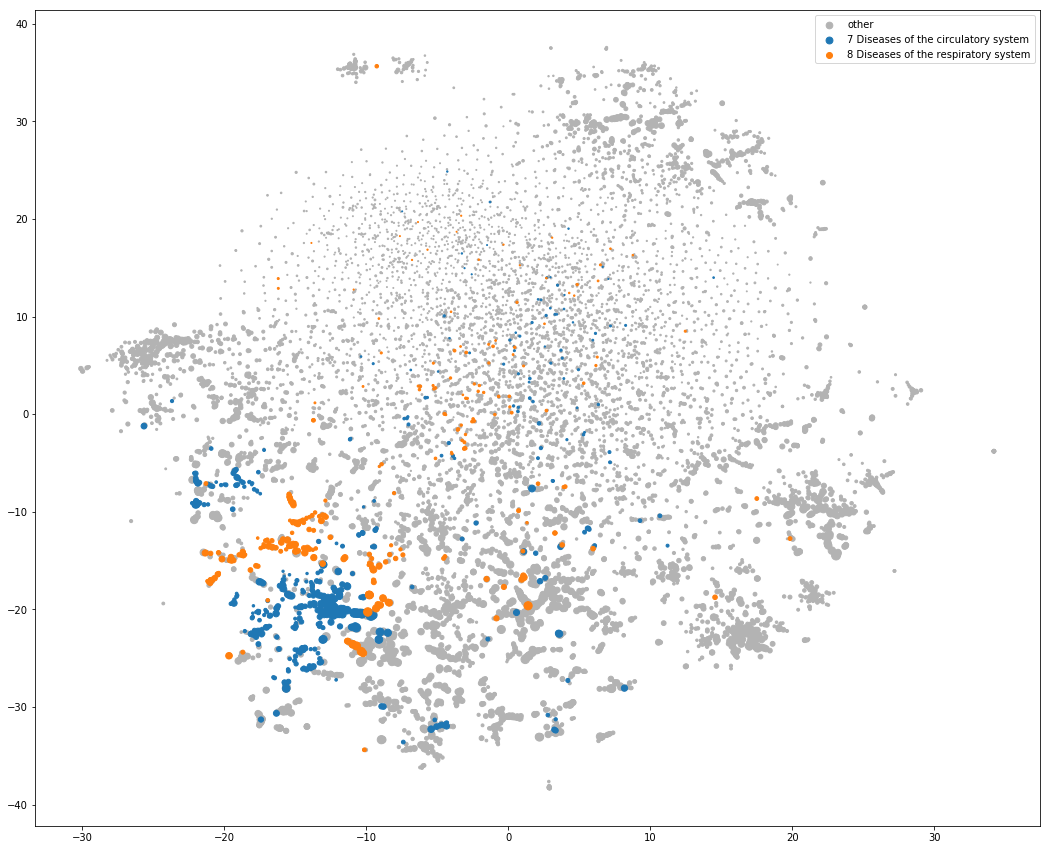

In [51]:
fig, ax = plt.subplots(figsize=(18, 15))
for ccs_lvl1, color in zip(gkey[:10], itertools.cycle(colors)):
    group = groups.get_group(ccs_lvl1)
    ax.scatter(group.x, group.y, marker='o', s=group.dot_size.values, label=ccs_lvl1, c=color)
    #plt.annotate(name, xy=(group.x.values, group.y.values), xytext=(group.x.values, group.y.values))
ax.legend()
#plt.savefig('plots/DX_embed_example78.png', dpi=200, bbox_inches='tight')

In [86]:
plot_df.loc[plot_df.ccs_lvl2=='7.2 Diseases of the heart', 'ccs_lvl3'].value_counts()

7.2.2 Peri-; endo-; and myocarditis; cardiomyopathy (except that caused by TB or STD) [97.]    40
7.2.3 Acute myocardial infarction [100.]                                                       28
7.2.1 Heart valve disorders [96.]                                                              28
7.2.8 Conduction disorders [105.]                                                              26
7.2.4 Coronary atherosclerosis and other heart disease [101.]                                  18
7.2.11 Congestive heart failure; nonhypertensive [108.]                                        16
7.2.7 Other and ill-defined heart disease [104.]                                               16
7.2.6 Pulmonary heart disease [103.]                                                           13
7.2.9 Cardiac dysrhythmias [106.]                                                              13
7.2.10 Cardiac arrest and ventricular fibrillation [107.]                                       3
7.2.5 Nonspecific ch

In [88]:
plot_df.loc[plot_df.ccs_lvl2=='8.1 Respiratory infections', 'ccs_lvl3'].value_counts()

8.1.1 Pneumonia (except that caused by TB or STD) [122.]    47
8.1.5 Other upper respiratory infections [126.]             30
8.1.2 Influenza [123.]                                      12
8.1.3 Acute and chronic tonsillitis [124.]                  10
8.1.4 Acute bronchitis [125.]                                3
Name: ccs_lvl3, dtype: int64

In [113]:
plot_df = plot_df.assign(label='other')
plot_df.loc[plot_df.ccs_lvl3=='7.2.3 Acute myocardial infarction [100.]', 'label'] = '7.2.3 Acute myocardial infarction [100.]'
plot_df.loc[plot_df.ccs_lvl3=='7.2.11 Congestive heart failure; nonhypertensive [108.]', 'label'] = '7.2.11 Congestive heart failure; nonhypertensive [108.]'
plot_df.loc[plot_df.ccs_lvl3=='8.1.1 Pneumonia (except that caused by TB or STD) [122.]', 'label'] = '8.1.1 Pneumonia (except that caused by TB or STD) [122.]'

In [114]:
#groups = plot_df.groupby('freq_label')
groups = plot_df.groupby('label')
gkey = groups.size().sort_values(ascending=False).index

In [115]:
colors = ['0.7', 'blue', 'red', 'green']

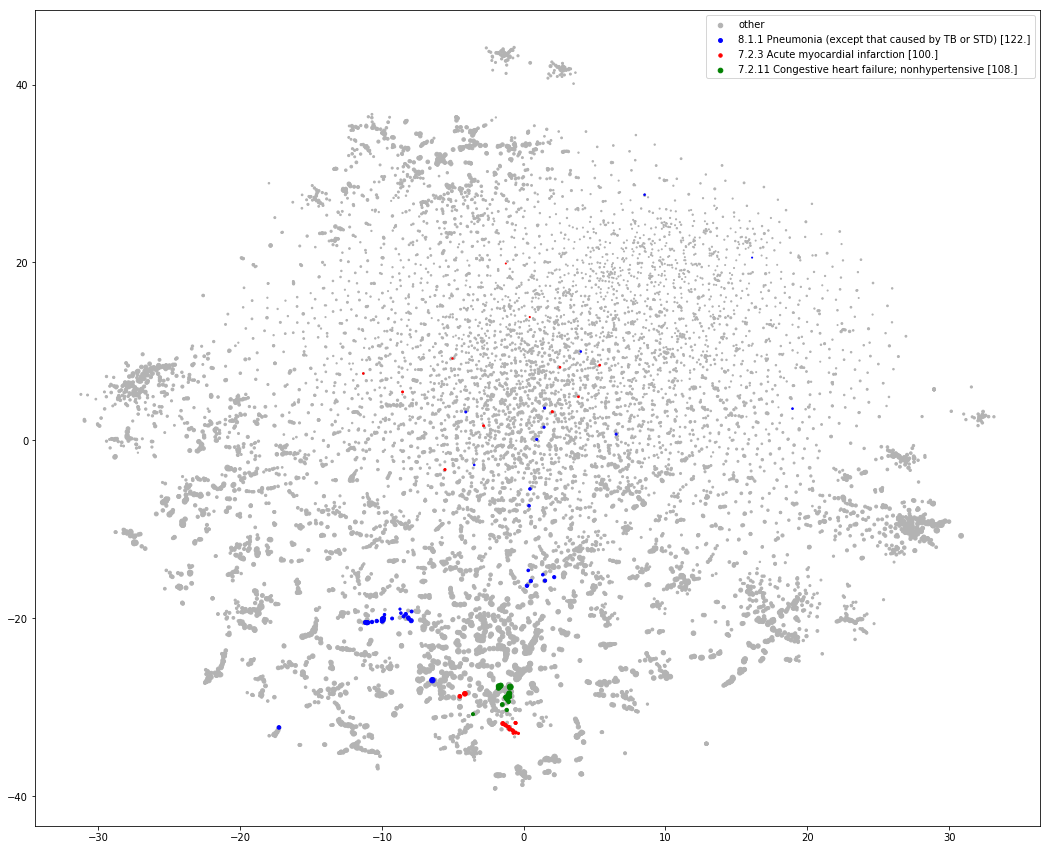

In [116]:
fig, ax = plt.subplots(figsize=(18, 15))
for ccs_lvl1, color in zip(gkey[:10], itertools.cycle(colors)):
    group = groups.get_group(ccs_lvl1)
    ax.scatter(group.x, group.y, marker='o', s=group.dot_size.values, label=ccs_lvl1, c=color)
    #plt.annotate(name, xy=(group.x.values, group.y.values), xytext=(group.x.values, group.y.values))
ax.legend()
plt.savefig('plots/DX_embed_example_cohorts.png', dpi=200, bbox_inches='tight')

### DX1 visualization

In [58]:
DX1_embed_mat_all = DX1_embed_mat.copy()

In [59]:
freq_cutpoint=10

In [60]:
DX1_cat_clean = sorted(DX1_freq.loc[DX1_freq.frequency>freq_cutpoint, 'DX1'].values)

In [61]:
DX1_embed_mat = DX1_embed_mat_all[(DX1_freq.frequency>freq_cutpoint).values, :]

In [62]:
len(DX1_cat_clean), DX1_embed_mat.shape

(6572, (6572, 200))

In [63]:
tsne = TSNE(n_components=2, init='random', random_state=0)

In [64]:
start = time.time()
DX_tsne = tsne.fit_transform(DX1_embed_mat)
print('Time used: {} sec'.format(time.time()-start))

Time used: 86.37021827697754 sec


In [65]:
plot_df = pd.DataFrame(dict(x=DX_tsne[:, 0], y=DX_tsne[:, 1]), index=DX1_cat_clean)

CCS category labels:

In [66]:
DX1_freq = DX1_freq.set_index(DX1_freq.DX1)

In [113]:
plot_df = plot_df.assign(ccs_lvl1=[dx_multi.loc[dx, 'CCS_LVL1']+' '+dx_multi.loc[dx, 'CCS_LVL1_LABEL'] for dx in plot_df.index])
plot_df = plot_df.assign(ccs_lvl2=[dx_multi.loc[dx, 'CCS_LVL2']+' '+dx_multi.loc[dx, 'CCS_LVL2_LABEL'] for dx in plot_df.index])
plot_df = plot_df.assign(ccs_lvl3=[dx_multi.loc[dx, 'CCS_LVL3']+' '+dx_multi.loc[dx, 'CCS_LVL3_LABEL'] for dx in plot_df.index])
plot_df = plot_df.assign(freq=DX1_freq.loc[plot_df.index, 'frequency'])
plot_df = plot_df.assign(dot_size=plot_df.freq.apply(lambda x:np.log(x+1)**2.3/10))

In [114]:
colors = ['C{}'.format(j) for j in range(10)]

In [115]:
#groups = plot_df.groupby('freq_label')
groups = plot_df.groupby('ccs_lvl1')
gkey = groups.size().sort_values(ascending=False).index

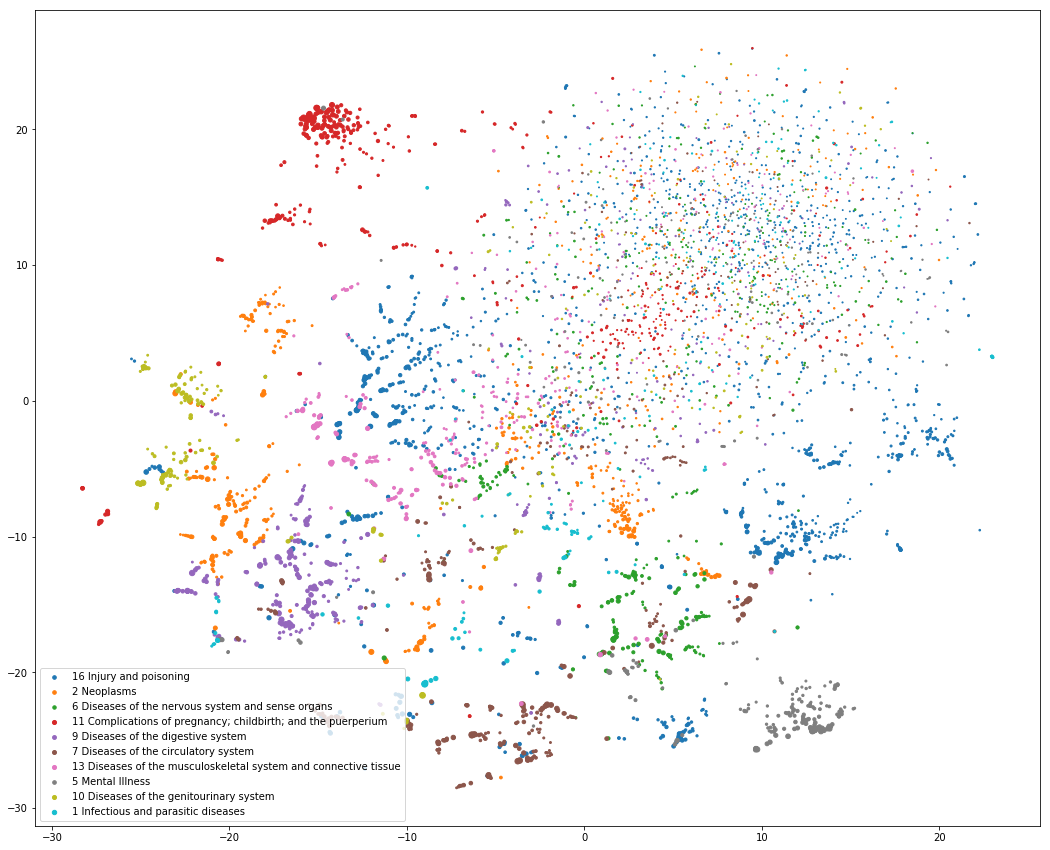

In [116]:
fig, ax = plt.subplots(figsize=(18, 15))
for ccs_lvl1, color in zip(gkey[:10], itertools.cycle(colors)):
    group = groups.get_group(ccs_lvl1)
    ax.scatter(group.x, group.y, marker='o', s=group.dot_size.values, label=ccs_lvl1, c=color)
    #plt.annotate(name, xy=(group.x.values, group.y.values), xytext=(group.x.values, group.y.values))
ax.legend()
plt.savefig('plots/DX1_embed_all10_200_200_50_20.png', dpi=300, bbox_inches='tight')

In [55]:
plot_df.ccs_lvl1.value_counts()

16 Injury and poisoning                                                                 1972
6 Diseases of the nervous system and sense organs                                       1060
2 Neoplasms                                                                              846
13 Diseases of the musculoskeletal system and connective tissue                          687
11 Complications of pregnancy; childbirth; and the puerperium                            680
9 Diseases of the digestive system                                                       544
1 Infectious and parasitic diseases                                                      497
7 Diseases of the circulatory system                                                     488
5 Mental Illness                                                                         483
10 Diseases of the genitourinary system                                                  444
14 Congenital anomalies                                               

In [47]:
plot_df = plot_df.assign(label='other')
plot_df.loc[plot_df.ccs_lvl1=='16 Injury and poisoning', 'label'] = '16 Injury and poisoning'
plot_df.loc[plot_df.ccs_lvl1=='11 Complications of pregnancy; childbirth; and the puerperium', 'label'] = '11 Complications of pregnancy; childbirth; and the puerperium'

In [148]:
plot_df = plot_df.assign(label='other')
plot_df.loc[plot_df.ccs_lvl1=='7 Diseases of the circulatory system', 'label'] = '7 Diseases of the circulatory system'
plot_df.loc[plot_df.ccs_lvl1=='8 Diseases of the respiratory system', 'label'] = '8 Diseases of the respiratory system'

In [144]:
plot_df = plot_df.assign(label='other')
plot_df.loc[plot_df.ccs_lvl1=='7 Diseases of the circulatory system', 'label'] = '7 Diseases of the circulatory system'
plot_df.loc[plot_df.ccs_lvl2=='7.2 Diseases of the heart', 'label'] = '7.2 Diseases of the heart'
plot_df.loc[plot_df.ccs_lvl3=='7.2.3 Acute myocardial infarction [100.]', 'label'] = '7.2.3 Acute myocardial infarction'

In [121]:
plot_df = plot_df.assign(label='other')
plot_df.loc[plot_df.ccs_lvl1=='8 Diseases of the respiratory system', 'label'] = '8 Diseases of the respiratory system'
plot_df.loc[plot_df.ccs_lvl2=='8.1 Respiratory infections', 'label'] = '8.1 Respiratory infections'
plot_df.loc[plot_df.ccs_lvl3=='8.1.1 Pneumonia (except that caused by TB or STD) [122.]', 'label'] = '8.1.1 Pneumonia (except that caused by TB or STD)'

In [149]:
#groups = plot_df.groupby('freq_label')
groups = plot_df.groupby('label')
gkey = groups.size().sort_values(ascending=False).index

In [150]:
colors = ['0.7'] + ['C{}'.format(j) for j in range(3)]

In [135]:
colors = ['0.8', 'lightsteelblue', 'cornflowerblue', 'royalblue']

In [133]:
colors = ['0.8', 'lightcoral', 'firebrick', 'red']

In [137]:
colors = ['0.8', 'yellowgreen', 'lawngreen', 'lime']

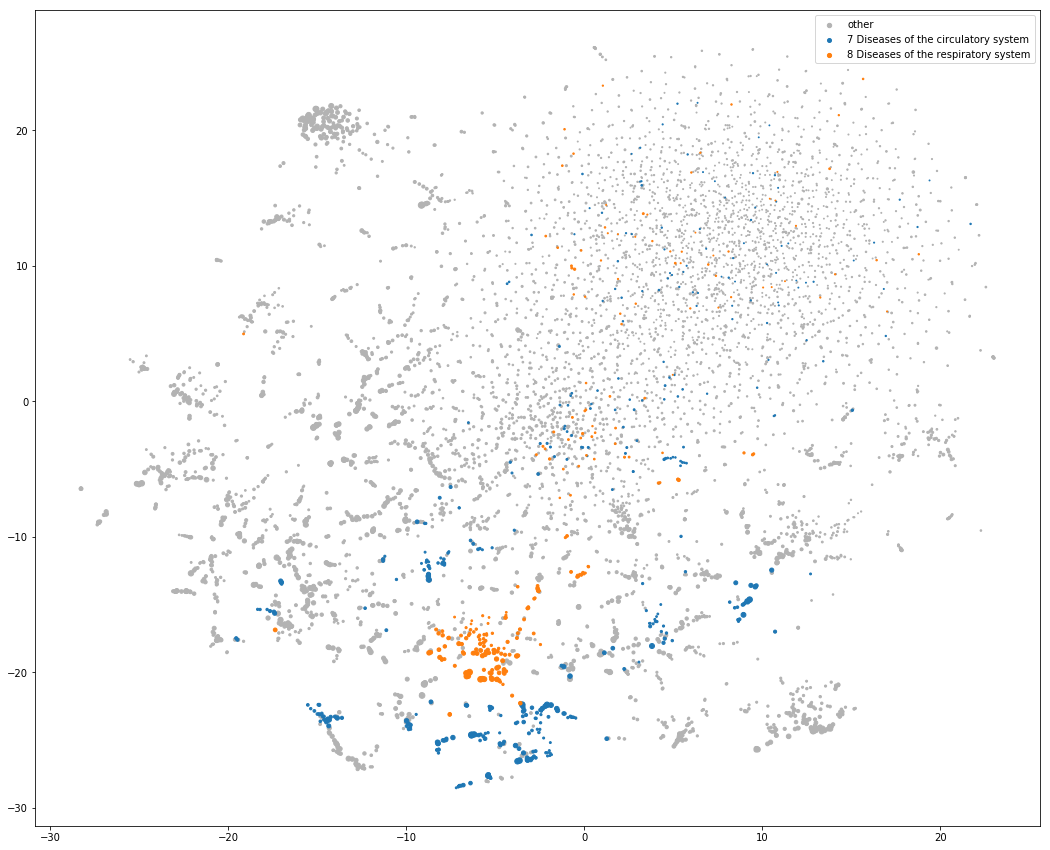

In [152]:
fig, ax = plt.subplots(figsize=(18, 15))
for ccs_lvl1, color in zip(gkey[:10], itertools.cycle(colors)):
    group = groups.get_group(ccs_lvl1)
    ax.scatter(group.x, group.y, marker='o', s=group.dot_size.values, label=ccs_lvl1, c=color)
    #plt.annotate(name, xy=(group.x.values, group.y.values), xytext=(group.x.values, group.y.values))
ax.legend()
plt.savefig('plots/DX1_embed_example78.png', dpi=300, bbox_inches='tight')

In [86]:
plot_df.loc[plot_df.ccs_lvl2=='7.2 Diseases of the heart', 'ccs_lvl3'].value_counts()

7.2.2 Peri-; endo-; and myocarditis; cardiomyopathy (except that caused by TB or STD) [97.]    40
7.2.3 Acute myocardial infarction [100.]                                                       28
7.2.1 Heart valve disorders [96.]                                                              28
7.2.8 Conduction disorders [105.]                                                              26
7.2.4 Coronary atherosclerosis and other heart disease [101.]                                  18
7.2.11 Congestive heart failure; nonhypertensive [108.]                                        16
7.2.7 Other and ill-defined heart disease [104.]                                               16
7.2.6 Pulmonary heart disease [103.]                                                           13
7.2.9 Cardiac dysrhythmias [106.]                                                              13
7.2.10 Cardiac arrest and ventricular fibrillation [107.]                                       3
7.2.5 Nonspecific ch

In [88]:
plot_df.loc[plot_df.ccs_lvl2=='8.1 Respiratory infections', 'ccs_lvl3'].value_counts()

8.1.1 Pneumonia (except that caused by TB or STD) [122.]    47
8.1.5 Other upper respiratory infections [126.]             30
8.1.2 Influenza [123.]                                      12
8.1.3 Acute and chronic tonsillitis [124.]                  10
8.1.4 Acute bronchitis [125.]                                3
Name: ccs_lvl3, dtype: int64

In [78]:
plot_df = plot_df.assign(label='other')
plot_df.loc[plot_df.ccs_lvl3=='7.2.3 Acute myocardial infarction [100.]', 'label'] = '7.2.3 Acute myocardial infarction [100.]'
plot_df.loc[plot_df.ccs_lvl3=='7.2.11 Congestive heart failure; nonhypertensive [108.]', 'label'] = '7.2.11 Congestive heart failure; nonhypertensive [108.]'
plot_df.loc[plot_df.ccs_lvl3=='8.1.1 Pneumonia (except that caused by TB or STD) [122.]', 'label'] = '8.1.1 Pneumonia (except that caused by TB or STD) [122.]'

In [79]:
#groups = plot_df.groupby('freq_label')
groups = plot_df.groupby('label')
gkey = groups.size().sort_values(ascending=False).index

In [80]:
colors = ['0.7']+ ['C{}'.format(j) for j in range(3)]

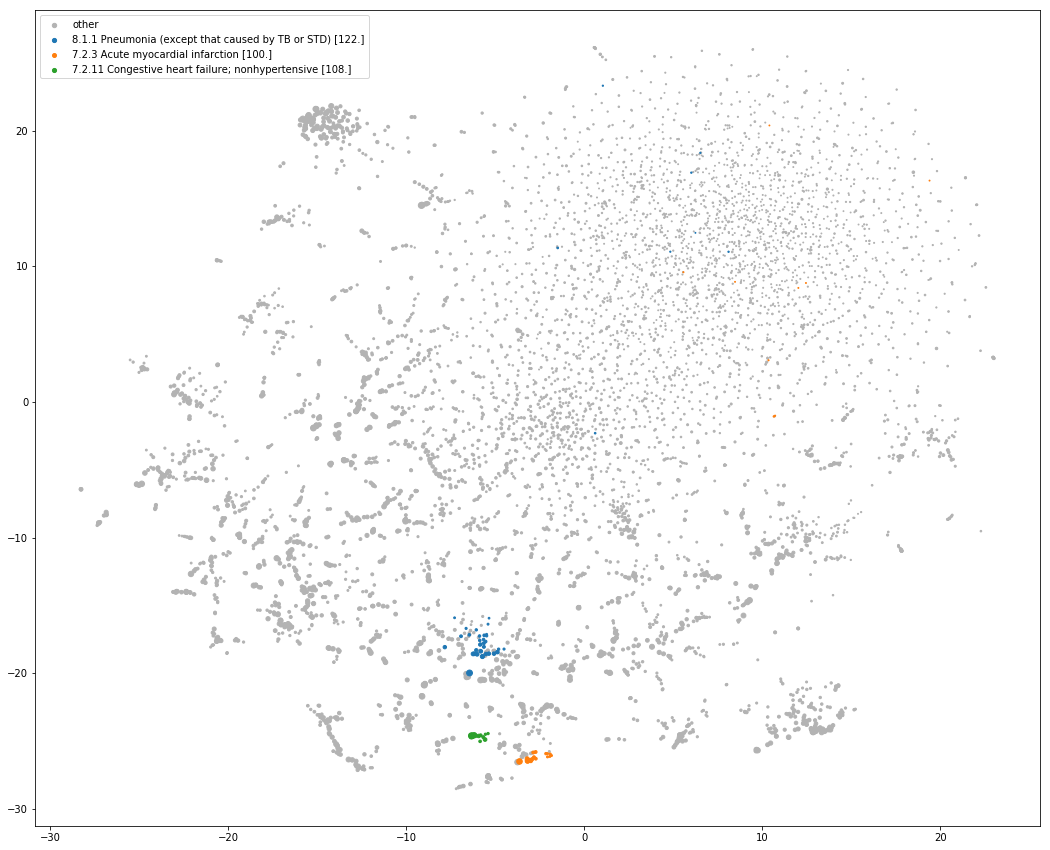

In [81]:
fig, ax = plt.subplots(figsize=(18, 15))
for ccs_lvl1, color in zip(gkey[:10], itertools.cycle(colors)):
    group = groups.get_group(ccs_lvl1)
    ax.scatter(group.x, group.y, marker='o', s=group.dot_size.values, label=ccs_lvl1, c=color)
    #plt.annotate(name, xy=(group.x.values, group.y.values), xytext=(group.x.values, group.y.values))
ax.legend()
#plt.savefig('plots/DX_embed_example_cohorts.png', dpi=200, bbox_inches='tight')

### Cohorts Visulization

In [82]:
ami_DX = ['41000', '41001', '41010', '41011', '41020', '41021', '41030', '41031', '41040', '41041', '41050', '41051', '41060', '41061', '41070', '41071', '41080', '41081', '41090', '41091']
chf_DX = ['40201', '40211', '40291', '40401', '40403', '40411', '40413', '40491', '40493', '4280', '4281', '42820', '42821', '42822', '42823', '42830', '42831', '42832', '42833', '42840', '42841', '42842', '42843', '4289']
pna_DX = ['4800', '4801', '4802', '4803', '4808', '4809', '481', '4820', '4821', '4822', '48230', '48231', '48232', '48239', '48240', '48241', '48242', '48249', '48281', '48282', '48283', '48284', '48289', '4829', '4830', '4831', '4838', '485', '486', '4870', '48811', '5070']

In [91]:
ami_DX = [dx for dx in ami_DX if dx in DX_cat_clean]
chf_DX = [dx for dx in chf_DX if dx in DX_cat_clean]
pna_DX = [dx for dx in pna_DX if dx in DX_cat_clean]

In [85]:
plot_df.head()

,x,y,ccs_lvl1,ccs_lvl2,ccs_lvl3,freq,dot_size,label
0020,15.052235,18.709864,9 Diseases of the digestive system,9.1 Intestinal infection [135.],,86,3.124586,other
0030,-14.471818,-13.347809,9 Diseases of the digestive system,9.1 Intestinal infection [135.],,1975,10.577964,other
0031,0.259093,-10.142707,1 Infectious and parasitic diseases,1.1 Bacterial infection,1.1.2 Septicemia (except in labor) [2.],674,7.446619,other
0038,18.446150,15.832770,9 Diseases of the digestive system,9.1 Intestinal infection [135.],,44,2.163974,other
0039,-0.083783,-2.511974,9 Diseases of the digestive system,9.1 Intestinal infection [135.],,158,4.181214,other


In [153]:
plot_df = plot_df.assign(label='other')

plot_df.loc[ami_DX, 'label'] = 'Acute myocardial infarction'
plot_df.loc[chf_DX, 'label'] = 'Heart failure'
plot_df.loc[pna_DX, 'label'] = 'Pneumonia'

In [103]:
plot_df.loc['5070', 'label'] = '507.0 Pneumonitis due to inhalation of food or vomitus'

In [102]:
dx_label.loc['5070']

dgns_cd                                                  5070
longdesc     Pneumonitis due to inhalation of food or vomitus
shortdesc                              Food/vomit pneumonitis
version                                                    31
fyear                                                    2014
Name: 5070, dtype: object

In [154]:
#groups = plot_df.groupby('freq_label')
groups = plot_df.groupby('label')
gkey = groups.size().sort_values(ascending=False).index

In [155]:
colors = ['0.7']+ ['C{}'.format(j) for j in range(3)]

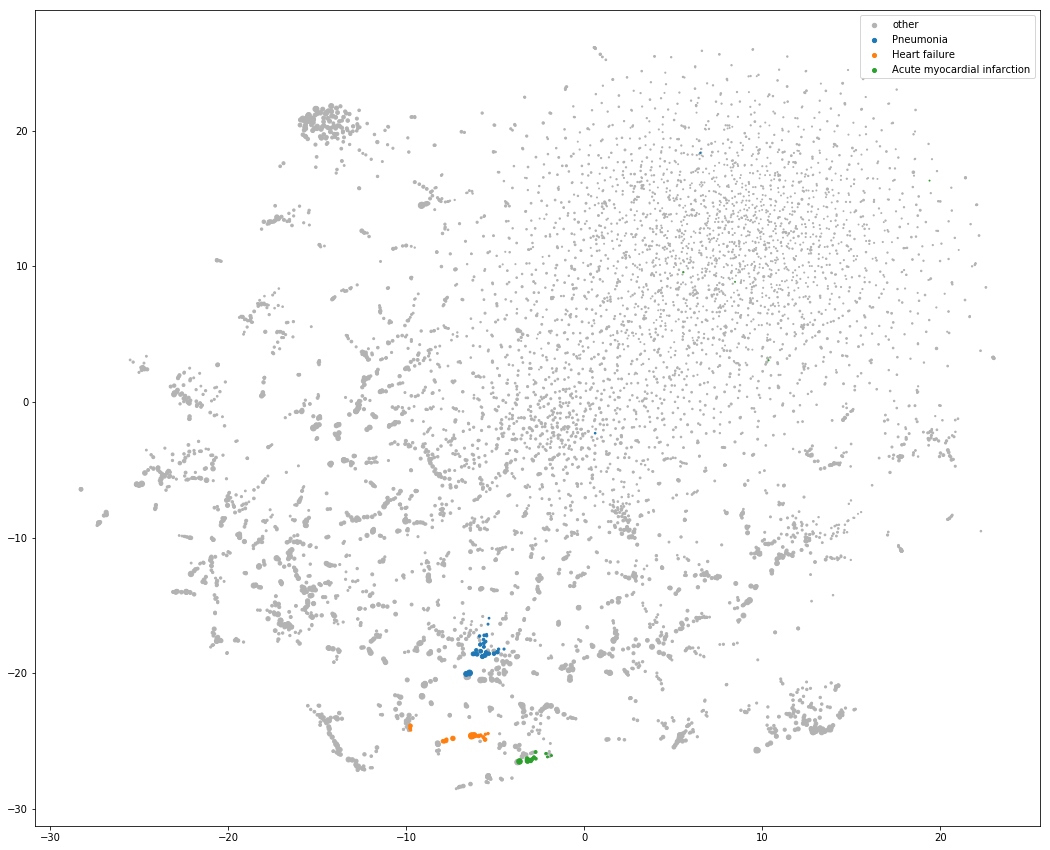

In [156]:
fig, ax = plt.subplots(figsize=(18, 15))
for ccs_lvl1, color in zip(gkey[:10], itertools.cycle(colors)):
    group = groups.get_group(ccs_lvl1)
    ax.scatter(group.x, group.y, marker='o', s=group.dot_size.values, label=ccs_lvl1, c=color)
    #plt.annotate(name, xy=(group.x.values, group.y.values), xytext=(group.x.values, group.y.values))
ax.legend()
plt.savefig('plots/DX1_embed_example_cohorts.png', dpi=300, bbox_inches='tight')